In [1]:
import cirq
from mitiq.benchmarks import generate_rb_circuits
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def execute(circuit: cirq.Circuit, noise_level: float = 0.01) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    if noise_level > 0:
        circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return cirq.DensityMatrixSimulator().simulate(circuit).final_density_matrix[0, 0].real

In [4]:
from mitiq.pec.pec import execute_with_pec
from mitiq.pec.representations import represent_operations_in_circuit_with_local_depolarizing_noise

exact_vals = []
um_vals = []
pec_vals = []
num_samples = []
noise_level = 0.01
num_cliffords = [10, 50, 100]
i = 0
for nc in tqdm(num_cliffords):
    circuit = generate_rb_circuits(n_qubits=1, num_cliffords=nc)[0]
    representations = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level=noise_level)
    exact_value = execute(circuit, noise_level=0)
    um_value = execute(circuit, noise_level=noise_level)
    pec_value, pec_data = execute_with_pec(
        circuit=circuit,
        executor=execute,
        representations=representations,
        precision=(0.2 * (i+1)),
        full_output=True
    )    

    exact_vals.append(exact_value)
    um_vals.append(um_value)
    pec_vals.append(pec_value)
    num_samples.append(pec_data['num_samples'])
    
    i += 1

100%|██████████| 3/3 [55:12<00:00, 1104.08s/it]


In [5]:
num_samples

[62, 406, 16830]

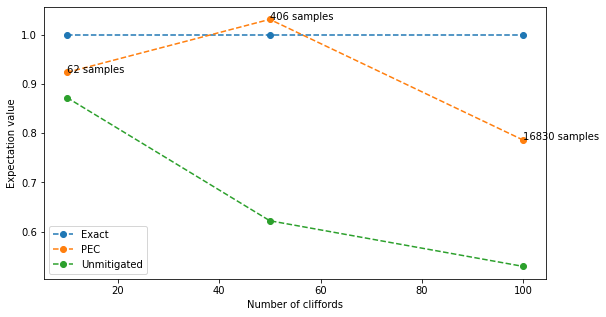

In [15]:
plt.figure(figsize=(9, 5))

plt.plot(num_cliffords, exact_vals, "--o", label="Exact")
plt.plot(num_cliffords, pec_vals, "--o", label="PEC")
plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

for i,_ in enumerate(num_samples):
    plt.text(num_cliffords[i], pec_vals[i], f'{num_samples[i]} samples')

plt.xlabel("Number of cliffords")
plt.ylabel("Expectation value")

plt.legend()
plt.savefig('images/pec.png', dpi=300, facecolor='white')
plt.show();

In [9]:
from mitiq.zne import execute_with_zne

exact_vals = []
um_vals = []
zne_vals = []
noise_level = 0.01
num_cliffords = [10, 50, 100]
for nc in tqdm(num_cliffords):
    circuit = generate_rb_circuits(n_qubits=1, num_cliffords=nc)[0]
    exact_value = execute(circuit, noise_level=0)
    um_value = execute(circuit, noise_level=noise_level)
    zne_val = execute_with_zne(circuit, execute)

    exact_vals.append(exact_value)
    um_vals.append(um_value)
    zne_vals.append(pec_value)    

100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


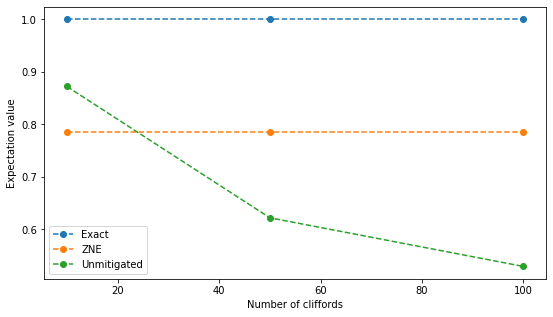

In [10]:
plt.figure(figsize=(9, 5))

plt.plot(num_cliffords, exact_vals, "--o", label="Exact")
plt.plot(num_cliffords, zne_vals, "--o", label="ZNE")
plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Number of cliffords")
plt.ylabel("Expectation value")

plt.legend()
plt.savefig('images/zne.png', dpi=300, facecolor='white')
plt.show();

In [29]:
from functools import partial
from mitiq.cdr import execute_with_cdr
from mitiq.interface.mitiq_cirq import compute_density_matrix
from cirq import T, inverse
import warnings

warnings.filterwarnings('ignore')

exact_vals = []
um_vals = []
cdr_vals = []
noise_level = 0.01
num_cliffords = [10, 50, 100]

simulate = partial(execute, noise_level=0)
for nc in tqdm(num_cliffords):
    circuit = generate_rb_circuits(n_qubits=1, num_cliffords=nc)[0]
    exact_value = execute(circuit, noise_level=0)
    um_value = execute(circuit, noise_level=noise_level)
    circuit.append(T.on_each(circuit.all_qubits()))
    circuit.append(inverse(T).on_each(circuit.all_qubits()))
    cdr_value = execute_with_cdr(circuit, execute, simulator=simulate)

    exact_vals.append(exact_value)
    um_vals.append(um_value)
    cdr_vals.append(cdr_value)

100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


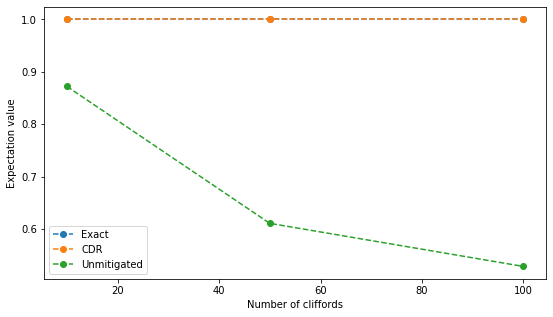

In [30]:
plt.figure(figsize=(9, 5))

plt.plot(num_cliffords, exact_vals, "--o", label="Exact")
plt.plot(num_cliffords, cdr_vals, "--o", label="CDR")
plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Number of cliffords")
plt.ylabel("Expectation value")

plt.legend()
plt.savefig('images/cdr.png', dpi=300, facecolor='white')
plt.show();